# The Search Algorithm

Here I will create the algorithm that decides which variations to play. I will be using a min max algorithm. This is basically an algorithm that skips variations that can't affect the algorithm.

Lets assume we are playing as white. The idea is that in each step (turn for a player) the algorithm will either minimize the eval or maximize it. Variations can be seen as trees (with corresponding roots, nodes and leafs). Suppose we evaluate to depth = n, where it is blacks turn. The algorithm will start by evaluating all the leafs of one of the previous nodes, since it is black's turn we assume black will try to play the best move (minimize evaluation). Therefore from that set of leafs, the only relevant leaf is the one with minimum evaluation. However we will chose the node that has min(set of leafs for node) the maximum from all nodes. This means that when evaluating the leafs of the next node we can stop (and skip to the next set of leafs for another node) whenever we find a leaf whose evaluation is less than the minimum at that point between all the leafs evaluated.

We can do this for each level, starting from the leafs of the tree upward toward the root.

I will start giving a fen to the algorithm as the input. For finding the variation I will use the Python - Chess Library. 

THINGS To do:
* Make engine think while it ins't its move (using the i's in alpha_beta algorithm) - **Done on algorithm, need to finish on engine.**
* Move ordering; consider best moves first. If best moves are considered first the alpha beta algorithm will be much faster (it breaks more times). I start by doing null move pruning.
* Use Pypy interpreter instead of CPython, since it is several magnitudes faster (except for numpy, so maybe we should avoid numpy).


**I have been using the python-chess library to compute the legal moves every time a move is made, however it is faster to precompute all the possible moves beforehand and store them in a table**

In [1]:
import numpy as np
import chess
from functools import partial # To preassign arguments of fucntions, creating a new function

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import time

# Test mod 8 methods
start_time = time.time()
for i in range(64):
    i % 8
end_time = time.time()
print(start_time-end_time)

start_time = time.time()
for i in range(64):
    divmod(i,8)
end_time = time.time()
print(start_time-end_time)

# Test mod 10 methods
start_time = time.time()
for i in range(64):
    i%10
end_time = time.time()
print(start_time-end_time)

start_time = time.time()
for i in range(64):
    divmod(i,10)
end_time = time.time()
print(start_time-end_time)

start_time = time.time()
for i in range(64):
    int(str(i)[-1])
end_time = time.time()
print(start_time-end_time)


-4.982948303222656e-05
-6.29425048828125e-05
-3.814697265625e-05
-3.600120544433594e-05
-5.507469177246094e-05


The fastest is i%10 however i%8 is also pretty fast, also it depends on the interpreter so it would be reasonable to try this with Pypy too. I will choose i%8, therefore my position will be a list of 64 elements. **Taking 100 has one further advantage, we are creating a 10 by 10 board and when checking if pieces are at the end of the board this is useful**. I will create a dictionary for each square type:
* Type 2: Where the knight only has 2 possible moves (i.e. corner squares)
* Type 3: The knight has 3 possible moves (i.e. squares beside corner squares (a2, b1, h7, g8, a7, b8, h7, g8))
* Type 4: The knight has 4 possible moves (edeg squares except the ones mentioned above and the squares b2, g2, b7, g7)
* Type 8: The knight has 8 moves (centre squares c3-f3, c4-f4,c5-f5,c6-f6)
* Type 6: The knight has 6 moves (the remaining squares)

I will be dividing the board in 4 squares and precomputing the moves on one of the 4 by 4 squares say (a1, a4, d1,d4). And using the symmetries I will be able to precompute all possible moves.


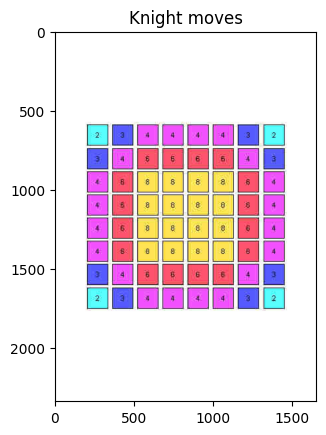

In [4]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("Knight moves")
 
image = mpimg.imread("Knight moves.png")
plt.imshow(image)
plt.show()

# Lists of possible moves for each square


In [78]:
N = 8
E = 1
S = -8
W = -1
directions_a1 = {#a1
    "P": {N, N+E, N+N, N+W}, # pawn will be dealt with on class since it depends on other things
    "N": {N+N+E, N+E+E}, # knight
    "B": {N+E:7}, #length of movement will be dealt inside class since it depends on other things
    "R": {N:7, E:7},
    "Q": {N:7, E:7, N+E:7},
    "K": {N, E, N+E},}
directions_b1 = { #b1
    "P": {N, N+E, N+N, N+W}, 
    "N": {N+N+E, N+E+E, N+N+W}, 
    "B": {N+E:6, N+W:1},
    "R": {N:7, E:6, W:1},
    "Q": {N:7, E:6, N+E:6, N+W:1, W:1},
    "K": {N, E, N+E, N+W, W},}
directions_a2 = { #a2
    "P": {N, N+E, N+N, N+W}, 
    "N": {N+N+E, N+E+E, S+E+E}, 
    "B": {N+E:6, S+E:1},
    "R": {N:6, E:7, S:1},
    "Q": {N:6, E:7, N+E:6, S:1, S+E:1},
    "K": {N, E, N+E, S, S+E},}
directions_c1 = { #c1
    "P": {N, N+E, N+N, N+W}, 
    "N": {N+N+E, N+E+E, N+N+W, N+W+W}, 
    "B": {N+E:5, N+W:2},
    "R": {N:7, E:5, W:2},
    "Q": {N:7, E:5, N+E:5, W:2, N+W:2},
    "K": {N, E, N+E, W, N+W},}
directions_d1 = { #d1
    "P": {N, N+E, N+N, N+W}, 
    "N": {N+N+E, N+E+E, N+N+W, N+W+W}, 
    "B": {N+E:4, N+W:3},
    "R": {N:7, E:4, W:3},
    "Q": {N:7, E:4, N+E:4, W:3, N+W:3},
    "K": {N, E, N+E, W, N+W},}
directions_a3 = { #a3
"P": {N, N+E, N+N, N+W},
"N": {N+N+E, N+E+E, S+E+E, S+S+E},
"B": {N+E:5, S+E:2},
"R": {N:5, E:7, S:2},
"Q": {N:5, E:7, N+E:5, S:2, S+E:2},
"K": {N, E, N+E, S, S+E},}
directions_a4 = { #a4 
"P": {N, N+E, N+N, N+W},
"N": {N+N+E, N+E+E, S+E+E, S+S+E},
"B": {N+E:4, S+E:3},
"R": {N:4, E:7, S:3},
"Q": {N:4, E:7, N+E:4, S:3, S+E:3},
"K": {N, E, N+E, S, S+E},}
directions_b2 = { #b2
"P": {N, N+E, N+N, N+W},
"N": {N+N+E, N+N+W, N+E+E, S+E+E},
"B": {N+E:6, N+W:1, S+E:1, S+W:1},
"R": {N:6, E:6, S:1, W:1},
"Q": {N:6, E:6, S:1, W:1, N+E:6, S+E:1, S+W:1, N+W:1},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},}
directions_b3 = { #b3
"P": {N, N+E, N+N, N+W},
"N": {N+N+E, N+N+W, N+E+E, S+E+E, S+S+E, S+S+W},
"B": {N+E:5, N+W:1, S+E:2, S+W:1},
"R": {N:5, E:6, S:2, W:1},
"Q": {N:5, E:6, S:2, W:1, N+E:5, S+E:2, S+W:1, N+W:1},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},}
directions_c2 = { #c2
"P": {N, N+E, N+N, N+W},
"N": {N+N+E,N+N+W, N+E+E, S+E+E, N+W+W, S+W+W},
"B": {N+E:5, N+W:2, S+E:1, S+W:1},
"R": {N:6, E:5, S:1, W:2},
"Q": {N:6, E:5, S:1, W:2, N+E:5, S+E:1, S+W:1, N+W:2},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},}
directions_c3 = { #centre squares c3
"P": {N, N+E, N+N, N+W},
"N": {N+N+E, N+E+E, S+E+E, S+S+E, S+S+W, S+W+W, N+W+W, N+N+W},
"B": {N+E:5, N+W:2, S+E:2, S+W:2},
"R": {N:5, E:5, S:2, W:2},
"Q": {N:5, E:5, S:2, W:2, N+E:5, S+E:2, S+W:2, N+W:2},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},}
directions_d3 = { #centre squares d3
"P": {N, N+E, N+N, N+W},
"N": {N+N+E, N+E+E, S+E+E, S+S+E, S+S+W, S+W+W, N+W+W, N+N+W},
"B": {N+E:4, N+W:3, S+E:2, S+W:2},
"R": {N:5, E:4, S:2, W:3},
"Q": {N:5, E:4, S:2, W:3, N+E:4, S+E:2, S+W:2, N+W:3},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},}
directions_c4 = { #centre squares c4
"P": {N, N+E, N+N, N+W},
"N": {N+N+E, N+E+E, S+E+E, S+S+E, S+S+W, S+W+W, N+W+W, N+N+W},
"B": {N+E:4, N+W:2, S+E:3, S+W:2},
"R": {N:4, E:5, S:3, W:2},
"Q": {N:4, E:5, S:3, W:2, N+E:4, S+E:3, S+W:2, N+W:2},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},}
directions_d4 = { #centre squares d4
"P": {N, N+E, N+N, N+W}, 
"N": {N+N+E, N+E+E, S+E+E, S+S+E, S+S+W, S+W+W, N+W+W, N+N+W}, 
"B": {N+E:4, N+W:3, S+E:3, S+W:3},
"R": {N:4, E:4, S:3, W:3},
"Q": {N:4, E:4, S:3, W:3, N+E:4, S+E:3, S+W:3, N+W:3},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},}
directions_b4 = { #b4
"P": {N, N+E, N+N, N+W}, 
"N": {N+N+E, N+E+E, S+E+E, S+S+E, S+S+W, S+W+W, N+W+W, N+N+W}, 
"B": {N+E:4, N+W:1, S+E:3, S+W:1},
"R": {N:4, E:7, S:3, W:1},
"Q": {N:4, E:7, S:3, W:1, N+E:4, S+E:3, S+W:1, N+W:1},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},    
}
directions_d2 = { #d2
"P": {N, N+E, N+N, N+W}, 
"N": {N+N+E, N+E+E, S+E+E, S+S+E, S+S+W, S+W+W, N+W+W, N+N+W}, 
"B": {N+E:4, N+W:3, S+E:1, S+W:1},
"R": {N:6, E:4, S:1, W:3},
"Q": {N:6, E:4, S:1, W:3, N+E:4, S+E:1, S+W:1, N+W:3},
"K": {N, E, S, W, N+E, S+E, S+W, N+W},    
}


In [68]:
DirectionsDict = {0: directions_a1, 1: directions_b1,
                  8: directions_a2, 2: directions_c1, 3:directions_d1,
                  16: directions_a3, 24: directions_a4, 9: directions_b2,
                  17: directions_b3, 25: directions_b4, 10: directions_c2, 
                  11: directions_d2, 18: directions_c3, 19: directions_d3,
                  26: directions_c4, 27: directions_d4}
DirectionsDict[1]


{'P': {7, 8, 9, 16},
 'N': {10, 15, 17},
 'B': {9: 6, 7: 1},
 'R': {8: 7, 1: 6, -1: 1},
 'Q': {8: 7, 1: 6, 9: 6, 7: 1, -1: 1},
 'K': {-1, 1, 7, 8, 9}}

In [3]:
board = [ 'R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R',          
         'P', 'P', 'r', 'P', 'klk', 'P', 'P', 'P',          
         '0', '0', '0', '0', '0', '0', '0', '0',          
         '0', '0', 'k', '0', '0', '0', '0', '0',       
         '0', '0', '0', '0', '0', '0', '0', '0',          
         '0', '2', 'm', '0', '0', '0', '0', '0',          
         'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p',          
         'r', 'n', 'b', 'q', 'k', 'b', 'n', 'k' ]

# Quadrant h8
flipboard = list(reversed(board)) # Flip the board pieces horizontally
flipsquarelist = list(reversed(range(64)))# correct
flipsquare = flipsquarelist[3]
print('Quadrant_h8:', flipboard) # Este esta hecho para h8


# Quadrant a8
flipboard = [square for row in [board[i:i+8] for i in range(0, 64, 8)][::-1] for square in row]
flipsquarelist = [square for row in [list(range(64))[::-1][i:i+8][::-1] for i in range(0, 64, 8)] for square in row]
flipsquare = flipsquarelist[3]
print('Quadrant_a8:', flipboard)

# Quadrant h1
flipboard = [square for row in [board[i:i+8][::-1] for i in range(0, 64, 8)] for square in row] 
flipsquarelist = [square for row in [list(range(64))[i:i+8][::-1] for i in range(0, 64, 8)] for square in row]
flipsquare = flipsquarelist[3]
print('Quadrant_h1:', flipboard) # Este esta hecho para h1


Quadrant_h8: ['k', 'n', 'b', 'k', 'q', 'b', 'n', 'r', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', '0', '0', '0', '0', '0', 'm', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'k', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'P', 'P', 'P', 'klk', 'P', 'r', 'P', 'P', 'R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
Quadrant_a8: ['r', 'n', 'b', 'q', 'k', 'b', 'n', 'k', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', '0', '2', 'm', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'k', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'P', 'P', 'r', 'P', 'klk', 'P', 'P', 'P', 'R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']
Quadrant_h1: ['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R', 'P', 'P', 'P', 'klk', 'P', 'r', 'P', 'P', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'k', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'm', '2', '0', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'k', 'n', 'b', 'k', 'q', 'b', 'n

In [49]:
flipboard = list(reversed(board)) # Flip the board pieces in both directions
flipsquare = list(reversed(range(64)))[61]
print(flipsquare)

2


In [69]:
#Position Class
from collections import namedtuple

Move = namedtuple("Move", "i j prom score") # The Move class is a named tuple that stores information about a
                                      # move in the chess game. It has three fields: i and j, which are 
                                      # the starting and ending positions of the piece being moved, respectively, 
                                      # and prom, which is the promotion piece if the move is a pawn promotion.
                                      # and score +2 captures
                                                # +1 checks
'''
¡¡¡
HE TENIDO LA IDEA DE CONSIDERAR LOS JAQUES, TENIENDO EN CUENTA LA POSICIÓN DEL REY. Y PARA CADA POSICIÓN HACER 
UN DICCIONARIO EN EL QUE PONEMOS LAS CASILLAS DESDE LAS  QUE PUEDE ATACARLE CADA PIEZA.
!!!
'''

class Position:#¡¡¡THE ONLY THING LEFT IS TO CHECK IN gen_moves THAT WHEN CASTLING THERES NO IN BETWEEN CHECKS!!!
    def __init__(self, board, psquare, wc, bc): # When creating a Position we will have to specify these variables
        self.board = board # an array of length 64
        self.psquare = psquare # An integer representing the square that can be captured using en passant.
                               # It will be -1 if the last move wasn't a double pawn move.
                               # I will change the passant variable every time a double pawn move is made in 
                               # the move method.
        self.wc = wc
        self.bc = bc # The castling rights, these will be lists of two Boolean variables. The first element 
                     # of the list represents kingside castle, the second queenside castle. They only check 
                     # if the king or rook has already moved (to check if there are in between checks we do
                     # it in gen_moves method).
        
    '''def pins(self):
        # I am going to create a method that returns the squares in which there is a pinned
        # piece of the player who's turn it is.
        FOR LATER, I WILL START BY NOT REDUCING THE POSSIBLE MOVES, BUT INSTEAD THE SEARCH
        ALGORITHM WILL IGNORE MOVING A PIN SINCE OTHERWISE THE KING WILL BE CAPTURED.
    '''
    def checks_pins(self):
        checks = [0]
        pins = {}
        for square, piece in enumerate(self.board):
            if piece not in 'prqnb':
                continue
            downwards = False
            flipsquare = square # flipsquare is the corresponding square in the first quarterboard
            flipsquarelist = list(range(64))
            flipboard = self.board
            if any(square in range(start, start+4) for start in [4, 12, 20, 28]): # h1 quadrant
                flipboard = [square for row in [self.board[i:i+8][::-1] for i in range(0, 64, 8)] for square in row] 
                flipsquarelist = [square for row in [list(range(64))[i:i+8][::-1] for i in range(0, 64, 8)] for square in row]
                flipsquare = flipsquarelist[square]                 
            elif any(square in range(start, start+4) for start in [36, 44, 52, 60]): # h8 quadrant
                # Quadrant h8
                downwards = True
                flipboard = list(reversed(self.board)) # Flip the board pieces horizontally
                flipsquarelist = list(reversed(range(64)))# correct
                flipsquare = flipsquarelist[square]
            elif any(square in range(start, start+4) for start in [32, 40, 48, 56]): # a8 quadrant
                # Quadrant a8
                downwards = True
                flipboard = [square for row in [self.board[i:i+8] for i in range(0, 64, 8)][::-1] for square in row]
                flipsquarelist = [square for row in [list(range(64))[::-1][i:i+8][::-1] for i in range(0, 64, 8)] for square in row]
                flipsquare = flipsquarelist[square]
            if piece in 'rqb': # Opponents sliders
                for d in DirectionsDict[flipsquare][piece.upper()].keys():
                    squareslist = [square]
                    count = 0
                    outer_break = False
                    for k in range(DirectionsDict[flipsquare][piece.upper()][d]):
                        jflip = flipsquare+(k+1)*d
                        j = flipsquarelist[jflip]
                        q = flipboard[jflip] # What is on destination square
                        if q.islower(): # Own piece is blocking
                            break
                        if q.isupper() and q!= 'K':
                            count += 1
                            pinned_square = j
                        if count >=2:
                            break
                        if q == 'K':
                            outer_break = True # No need to check for other directions
                            if count == 0:
                                checks[0]+=1
                                checks.append(squareslist)
                            else:
                                pins[pinned_square]=squareslist
                            break
                        squareslist.append(j)
                    if outer_break:
                        break             
            else: #Opponents Crawlers
                for d in DirectionsDict[flipsquare][piece.upper()]:
                    d1 = d
                    if piece == 'P' and downwards:
                        if d == 7:
                            d1 = -9
                        if d == 9:
                            d1 = -7
                        if d == 8:
                            d1 = -8
                    jflip = flipsquare + d1
                    j = flipsquarelist[jflip]
                    q = self.board[j] # What is on destination square
                    if q == 'K':
                        checks[0]+=1
                        checks.append([square])
        return [checks, pins]
    def gen_moves(self):
        # The gen_moves method generates all legal moves for the current position, and returns 
        # a generator that yields Move objects. It iterates through each of the player's pieces 
        # on the board and, for each piece, iterates through each possible 'ray' of moves, as 
        # defined in the directions map. The rays are broken by captures or immediately in the 
        # case of pieces such as knights.
        checks_pins = self.checks_pins()
        checks = checks_pins[0]
        pins = checks_pins[1]
        for square, piece in enumerate(self.board):
            # MAYBE INSTEAD OF CREATING FLIPBOARD AND FLIPSQUARE WE CAN CREATE A FOR LOOP, RUNNING THROUGH
            # THE DIRECTIONS ON EACH OF THE 4 BY 4 QUARTERBOARDS, I WILL CHECK WHEN FINISHED IF THIS IS MORE
            # EFFICIENT(MAYBE BECAUSE LESS MEMORY USAGE?).
            downwards = False
            flipsquare = square # flipsquare is the corresponding square in the first quarterboard
            flipsquarelist = list(range(64))
            flipboard = self.board
            if not piece.isupper(): # We only check for white pieces(rotation will allow then to check for black)
                continue
            if any(square in range(start, start+4) for start in [4, 12, 20, 28]): # h1 quadrant
                flipboard = [square for row in [self.board[i:i+8][::-1] for i in range(0, 64, 8)] for square in row] 
                flipsquarelist = [square for row in [list(range(64))[i:i+8][::-1] for i in range(0, 64, 8)] for square in row]
                flipsquare = flipsquarelist[square]                 
            elif any(square in range(start, start+4) for start in [36, 44, 52, 60]): # h8 quadrant
                # Quadrant h8
                downwards = True
                flipboard = list(reversed(self.board)) # Flip the board pieces horizontally
                flipsquarelist = list(reversed(range(64)))# correct
                flipsquare = flipsquarelist[square]
            elif any(square in range(start, start+4) for start in [32, 40, 48, 56]): # a8 quadrant
                # Quadrant a8
                downwards = True
                flipboard = [square for row in [self.board[i:i+8] for i in range(0, 64, 8)][::-1] for square in row]
                flipsquarelist = [square for row in [list(range(64))[::-1][i:i+8][::-1] for i in range(0, 64, 8)] for square in row]
                flipsquare = flipsquarelist[square]
            if piece in 'RQB' and checks[0]==0: # Sliders without checks
                outer_continue = False  # flag variable to indicate whether to break out of outer loop
                for d in DirectionsDict[flipsquare][piece].keys():
                    for k in range(DirectionsDict[flipsquare][piece][d]):
                        score = 0
                        jflip = flipsquare+(k+1)*d
                        j = flipsquarelist[jflip]
                        if square in pins.keys(): # If piece is pinned we can only move through pin
                            if j not in pins[square]:
                                break
                        q = flipboard[jflip] # What is on destination square
                        if q.isupper():
                            break # we cant move if our own piece is blocking
                        if q.islower():
                            score += 2 # capture
                        yield Move(square, j, "", score)
                        # Captures prevent more moves in that direction
                        if q.islower(): # For the rest yield will give a sequence of moves
                            break
                        # Castling, by sliding the rook next to the king 
                        if square == 0 and self.board[j + E] == "K" and self.wc[0]:
                            position1 = self
                            position2 = self
                            if position1.move(Move(j+E, j, '', 0)).rotate().checks_pins()[0][0]!=0 or position1.move(Move(j+E, j+W, '', 0)).rotate().checks_pins()[0][0]!=0:
                                break
                            yield Move(j + E, j + W, "", score) # castling is represented by the king move (makes 
                                                 # move method easier)
                        if square == 7 and self.board[j + W] == "K" and self.wc[1]:
                            position1 = self
                            position2 = self
                            if position1.move(Move(j+W, j, '', 0)).rotate().checks_pins()[0][0]!=0 or position1.move(Move(j+W, j+E, '', 0)).rotate().checks_pins()[0][0]!=0:
                                break
                            yield Move(j + W, j + E, "", score)
            elif piece in 'NKP' and checks[0]==0: # Crawlers without checks
                for d in DirectionsDict[flipsquare][piece]:
                    score = 0
                    d1 = d
                    if piece == 'P' and downwards:
                        if d == 7:
                            d1 = -9
                        if d == 9:
                            d1 = -7
                        if d == 8:
                            d1 = -8
                    jflip = flipsquare + d1
                    j = flipsquarelist[jflip]
                    if square in pins.keys(): # If piece is pinned we can only move through pin
                        if j not in pins[square]:
                            break
                    if piece == 'K': # Making sure we dont move the king in check
                        position1 = self
                        if position1.move(Move(square, j, '', score)).rotate().checks_pins()[0][0] != 0:
                            continue
                    q = self.board[j] # What is on destination square
                    if q.isupper():
                        continue # we cant move if our own piece is blocking
                    if piece == "P": # Pawn move, double move and capture
                        if d in (N, N+N) and q != "0": # can't move
                            continue 
                        if d == N+N and (square > 15 or flipboard[flipsquare + N] != "0"): # can't move twice
                            continue
                        if (d in (N+W, N+E) and q == "0" and self.psquare != j): 
                            continue # Can't capture or en passant 
                        if 56 <= j: # If we move to the last row, we can promote
                            for prom in "NBRQ":
                                yield Move(square, j, prom, score)
                            continue
                    if q.islower():
                        score += 2
                    # Move it
                    yield Move(square, j, "", score)
                    # Captures prevent more moves in that direction
                    if q.islower(): # For the rest yield will give a sequence of moves
                        continue
            elif piece in 'RQB' and checks[0] == 1: # In 1 check, Sliders can be captured, blocked or move king
                if square in pins.keys(): # If check, pinned pieces cant move
                    continue
                for d in DirectionsDict[flipsquare][piece].keys():
                    for k in range(DirectionsDict[flipsquare][piece][d]):
                        score = 0
                        jflip = flipsquare+(k+1)*d
                        j = flipsquarelist[jflip]
                        q = flipboard[jflip] # What is on destination square
                        if q.isupper(): # we cant move more in that direction
                            break
                        if j not in checks[1]:
                            continue # We don't interfere with check
                        if q.islower():
                            score += 2
                        yield Move(square, j, '', score)
            elif piece in 'NPK' and checks[0] == 1: # In 1 check, Only capture or move king
                if square in pins.keys(): # If check, pinned pieces cant move
                    continue
                for d in DirectionsDict[flipsquare][piece]:
                    score = 0
                    d1 = d
                    if piece == 'P' and downwards:
                        if d == 7:
                            d1 = -9
                        if d == 9:
                            d1 = -7
                        if d == 8:
                            d1 = -8
                    jflip = flipsquare + d1
                    j = flipsquarelist[jflip]
                    if j not in checks[1] and piece != 'K':
                        continue
                    if piece == 'K': # Making sure we dont move the king in check
                        position1 = self
                        if position1.move(Move(square, j, '', score)).rotate().checks_pins()[0][0] != 0:
                            continue
                    q = self.board[j] # What is on destination square
                    if q.islower():
                        score += 2
                    if piece == "P": # Pawn move, double move and capture
                        if d in (N, N+N) and q != "0": # can't move
                            continue 
                        if d == N+N and (square > 15 or flipboard[flipsquare + N] != "0"): # can't move twice
                            continue
                        if (d in (N+W, N+E) and q == "0" and self.psquare != j): 
                            continue # Can't capture or en passant 
                        if 56 <= j: # If we move to the last row, we can promote
                            for prom in "NBRQ":
                                yield Move(square, j, prom, score)
                            continue
                    yield Move(square,j, '', score)
            else: # There are multiple checks so we may only move king
                if piece != 'K':
                    continue
                for d in DirectionsDict[flipsquare]['K']:
                    score = 0
                    jflip = flipsquare + d
                    j = flipsquarelist[jflip]
                    if piece == 'K': # Making sure we dont move the king in check
                        position1 = self
                        if position1.move(Move(square, j, '', score)).rotate().checks_pins()[0][0] != 0:
                            continue
                    q = self.board[j]
                    if q.isupper():
                        continue
                    if q.islower():
                        score += 2
                    yield Move(square, j, '', score)
                    
    def rotate(self): 
        # Switch the roles of black and white. It also swaps the case of all the pieces and preserves 
        # en passant unless it is a null move. White's castling rights become black's and viceversa.
        return Position([x.swapcase() for x in self.board[::-1]], self.psquare, self.bc, self.wc)
        
    def move(self, move):
        # The move method takes a Move object as an argument and returns a new Position 
        # object representing the state of the game after the move has been made. It first 
        # checks if the move is castling, pawn promotion, or en passant, and updates the 
        # board accordingly. It then updates the castling rights and en passant square if 
        # necessary, and rotates the board to return a new Position object.
        i, j, prom, capt = move # prom is the letter representing the piece we are promoting to 
        piece, q, board = self.board[i], self.board[j], self.board # piece and destination piece/space
        wc, bc = self.wc, self.bc
        put = lambda board, i, p: board[:i] + [p] + board[i+1:]
        newpsquare, newwc, newbc = -1, self.wc, self.bc 
        # Actual move
        newboard = put(self.board, j, self.board[i])
        newboard = put(newboard, i, ".")
        # If we move the rook or capture the opponent's the castling rights are lost
        if i == 0: wc = (False, wc[1])
        if i == 7: wc = (wc[0], False)
        if j == 56: bc = (bc[0], False)
        if j == 63: bc = (False, bc[1])
        # Castling 
        if piece == "K":
            wc = (False, False) # if king moves then player can't castle
            if abs(j - i) == 2: # if castling...
                board = put(board, 0 if j < i else 7, ".")
                board = put(board, 2 if j < i else 4, "R")
        # Pawn promotion, double move and en passant capture
        if piece == "P":
            if 56 <= j:
                board = put(board, j, prom) # changing the pawn to the promoting piece
            if j - i == N + N: # If we move pawn two squares, the enpassant square becomes...
                newpsquare = i + N    
            if j == self.psquare: # If we capture en passant
                board = put(board, j + S, ".")
        # We rotate the returned position, so it's ready for the next player
        return Position(newboard, newpsquare, newwc, newbc).rotate()
    

In [70]:
board = [ 'R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R',          
         'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',          
         '0', '0', '0', '0', '0', '0', '0', '0',          
         '0', '0', '0', '0', '0', '0', '0', '0',       
         '0', '0', '0', '0', '0', '0', '0', '0',          
         '0', '0', '0', '0', '0', '0', '0', '0',          
         'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p',          
         'r', 'n', 'b', 'q', 'k', 'b', 'n', 'k' ]
print(list(Position(board,-1,[True, True], [True, True]).gen_moves()))

[Move(i=1, j=18, prom='', score=0), Move(i=1, j=16, prom='', score=0), Move(i=6, j=21, prom='', score=0), Move(i=6, j=23, prom='', score=0), Move(i=8, j=16, prom='', score=0), Move(i=8, j=24, prom='', score=0), Move(i=9, j=17, prom='', score=0), Move(i=9, j=25, prom='', score=0), Move(i=10, j=18, prom='', score=0), Move(i=10, j=26, prom='', score=0), Move(i=11, j=19, prom='', score=0), Move(i=11, j=27, prom='', score=0), Move(i=12, j=20, prom='', score=0), Move(i=12, j=28, prom='', score=0), Move(i=13, j=21, prom='', score=0), Move(i=13, j=29, prom='', score=0), Move(i=14, j=22, prom='', score=0), Move(i=14, j=30, prom='', score=0), Move(i=15, j=23, prom='', score=0), Move(i=15, j=31, prom='', score=0)]


In [76]:
position1 = fen_to_position('8/5K2/8/8/8/8/b7/6r1 w - - 0 1')
print(list(position1.gen_moves()))

[Move(i=53, j=52, prom='', score=0), Move(i=53, j=45, prom='', score=0), Move(i=53, j=61, prom='', score=0), Move(i=53, j=60, prom='', score=0)]


### The Algorithm

I am creating to algorithms, one which runs with the python chess library (alpha_beta_from_fen) and the other with my move generator. My move generator appears to make the algorithm 50 times faster.

In [79]:
import chess
def alpha_beta_from_fen(fen, depth, alpha, beta, maximize, evaluate_position): 
    # maximize is a boolean variable (True if we want to maximize the evaluation (we are white))
    # alpha is the current best evaluation for white, it will start at -infinity
    # beta is the current best evaluation for black, it will start at +infinity
    
    board = chess.Board(fen = fen)
    legal_moves = list(board.legal_moves)
    
    if depth == 0:
        return evaluate_position(fen), []
    
    best_move = None
    variation = []
    
    if maximize:
        value = -np.inf
        for move in legal_moves:
            board.push(move)
            child_value, child_variation = alpha_beta_from_fen(board.fen(), depth - 1, alpha, beta, False, evaluate_position)
            if child_value > value:
                value = child_value
                best_move = move
                variation = [best_move] + child_variation
            board.pop() # Unmake the last move
            alpha = max(alpha, value)
            if alpha >= beta:
                break
    else:
        value = np.inf
        for move in legal_moves:
            board.push(move)
            child_value, child_variation = alpha_beta_from_fen(board.fen(), depth - 1, alpha, beta, True, evaluate_position)
            if child_value < value:
                value = child_value
                best_move = move
                variation = [best_move] + child_variation
            board.pop() 
            beta = min(beta, value)
            if beta <= alpha:
                break
    
    return value, variation


In [80]:
def alpha_beta_from_position(position, depth, alpha, beta, maximize):
    # maximize is a boolean variable (True if we want to maximize the evaluation (we are moving))
    # alpha is the current best evaluation for white, it will start at -infinity
    # beta is the current best evaluation for black, it will start at +infinity
    if depth == 0 and maximize:
        return evaluate_position_from_board(position.board), []
    if depth == 0 and not maximize:
        return -evaluate_position_from_board(position.board), [] # This is because we are rotating the board
                                                                 # and black is playing as white
    
    legal_moves = position.gen_moves()
    best_move = None
    variation = []
    
    if maximize: 
        value = -np.inf
        for move in legal_moves:
            position1 = position
            child_value, child_variation = alpha_beta_from_position(position1.move(move), depth - 1, alpha, beta, False)
            if child_value > value:
                value = child_value
                best_move = move
                variation = [best_move] + child_variation
            alpha = max(alpha, value)
            if alpha >= beta:
                break
    else:
        value = np.inf
        for move in legal_moves:
            position1 = position
            child_value, child_variation = alpha_beta_from_position(position1.move(move), depth - 1, alpha, beta, True)
            if child_value < value:
                value = child_value
                best_move = move
                variation = [best_move] + child_variation
            beta = min(beta, value)
            if alpha >= beta:
                break
    
    return value, variation if maximize else -value, variation

Im creating a simple evaluation function, just to test the how fast the code runs and improve it.

In [81]:
def evaluate_position_from_fen(fen): # Simple position evaluation to check engine algorithm
    board = chess.Board(fen)
    material_value = {
        "P": 1, "N": 3, "B": 3, "R": 5, "Q": 9,
        "p": -1, "n": -3, "b": -3, "r": -5, "q": -9
    }
    total_material = 0
    for piece in fen.split()[0]:
        if piece in material_value:
            total_material += material_value[piece]
    return total_material

def evaluate_position_from_board(board): # Simple position evaluation to check engine algorithm
    material_value = {
        "P": 1, "N": 3, "B": 3, "R": 5, "Q": 9,
        "p": -1, "n": -3, "b": -3, "r": -5, "q": -9
    }
    total_material = 0
    for piece in board:
        if piece in material_value:
            total_material += material_value[piece]
    return total_material

In [143]:
import time

start_time = time.time()

# Example FEN string
fen = "r2qkbnr/1bp2ppp/1pnp4/pB2p3/3PP3/2N2N2/PPP2PPP/R1BQ1RK1 w kq - 2 7"

depth = 5
alpha = -np.inf
beta = np.inf
maximize = True
best_move = None
best_value = -np.inf

board = chess.Board(fen)
legal_moves = list(board.legal_moves)

for move in legal_moves:
    board.push(move)
    new_fen = board.fen()
    x = alpha_beta_from_fen(new_fen, depth - 1, alpha, beta, not maximize, evaluate_position)
    board.pop()

    if x[0] > best_value:
        best_move = move
        best_value = x[0]
        variation = [move] + x[1]

print("Best move: ", best_move)
print("Value: ", best_value)
end_time = time.time()
elapsed_time = end_time - start_time

print("Time taken:", elapsed_time, "seconds")
print('Variation:', variation)


Best move:  d4e5
Value:  4
Time taken: 178.04738402366638 seconds
Variation: [Move.from_uci('d4e5'), Move.from_uci('g8e7'), Move.from_uci('f3g5'), Move.from_uci('h8g8'), Move.from_uci('b5c6')]


In [11]:
def fen_to_position(fen):
    board = ['0']*64
    fen_parts = fen.split()
    fen_board = fen_parts[0].split('/')
    for i in range(len(fen_board)):
        fen_row = fen_board[i]
        j = 0
        for c in fen_row:
            if c.isdigit():
                j += int(c)
            else:
                board[(7-i)*8+j] = c
                j += 1
    
    en_passant = chess.SQUARE_NAMES.index(fen_parts[3]) if fen_parts[3] != '-' else -1
    
    white_castling_rights = [False]*2
    if 'K' in fen_parts[2]:
        white_castling_rights[0] = True
    if 'Q' in fen_parts[2]:
        white_castling_rights[1] = True
    black_castling_rights = [False]*2
    if 'k' in fen_parts[2]:
        black_castling_rights[0] = True
    if 'q' in fen_parts[2]:
        black_castling_rights[1] = True
    
    return Position(board, en_passant, white_castling_rights, black_castling_rights)
fen_to_position('r2qkbnr/1bp2ppp/1pnp4/pB2p3/3PP3/2N2N2/PPP2PPP/R1BQ1RK1 w kq - 2 7').board

['R',
 '0',
 'B',
 'Q',
 '0',
 'R',
 'K',
 '0',
 'P',
 'P',
 'P',
 '0',
 '0',
 'P',
 'P',
 'P',
 '0',
 '0',
 'N',
 '0',
 '0',
 'N',
 '0',
 '0',
 '0',
 '0',
 '0',
 'P',
 'P',
 '0',
 '0',
 '0',
 'p',
 'B',
 '0',
 '0',
 'p',
 '0',
 '0',
 '0',
 '0',
 'p',
 'n',
 'p',
 '0',
 '0',
 '0',
 '0',
 '0',
 'b',
 'p',
 '0',
 '0',
 'p',
 'p',
 'p',
 'r',
 '0',
 '0',
 'q',
 'k',
 'b',
 'n',
 'r']

In [83]:
def engine_fen(fen, is_maximizing_player, is_our_move, depth): # ¡¡¡ FIX AND ADD VARIATIONS!!!
    # is_maximizing_player is set to True if we are white
    # alpha is the current best evaluation for white, it will start at -infinity
    # beta is the current best evaluation for black, it will start at +infinity
    start_time = time.time()
    best_move = None
    board = chess.Board(fen)
    legal_moves = list(board.legal_moves)

    if is_our_move:
        if is_maximizing_player:
            alpha = -np.inf
            beta = np.inf
            best_value = -np.inf
        else:
            alpha = -np.inf
            beta = np.inf
            best_value = np.inf
        
        for move in legal_moves:
            board.push(move)
            new_fen = board.fen()
            value = alpha_beta_from_fen(new_fen, depth - 1, alpha, beta, not is_maximizing_player, evaluate_position_from_fen)[0]
            board.pop()

            if is_maximizing_player and value > best_value:
                best_move = move
                best_value = value
            elif is_maximizing_player==False and value < best_value:
                best_move = move
                best_value = value
        end_time = time.time()
        elapsed_time = end_time - start_time
        return ["Time taken:", elapsed_time, "seconds", "Best move: ", best_move, "Evaluation: ", best_value]
    else: # Now we make the engine think while it isn't it's turn
        Dict = {}
        for move in legal_moves:
            board.push(move)
            new_fen = board.fen()
            best_move = None
            Dict[move]=(engine(fen, is_maximizing_player, is_our_move, depth+1)[4], 
                        engine(fen, is_maximizing_player, is_our_move, depth+1)[6])
        return(Dict) # This is a dictionary of the form {move: best response, evaluation}
        

In [ ]:
engine_fen('r2qkbnr/1bp2ppp/1pnp4/pB2p3/3PP3/2N2N2/PPP2PPP/R1BQ1RK1 w kq - 2 7', True, True, 5)

This is the best move, in a position where we are black and it is our move. For a search of depth 5, it takes 154 seconds which should be improved, it is finding the best move in a simple capture. Note that we are using a very simple evaluation function which will be faster than the true one.

In [64]:
import time
import numpy as np
def engine_position(position, is_maximizing_player, is_our_move, depth): # ¡¡¡FIX AND ADD VARIATIONS!!!
    # alpha is the current best evaluation for white, it will start at -infinity
    # beta is the current best evaluation for black, it will start at +infinity
    start_time = time.time()
    best_move = None
    legal_moves = position.gen_moves()

    if is_our_move:
        if is_maximizing_player:
            alpha = -np.inf
            beta = np.inf
            best_value = -np.inf
        else:
            alpha = -np.inf
            beta = np.inf
            best_value = np.inf
        
        for move in legal_moves:
            new_position = position.move(move)
            value = alpha_beta_from_position(new_position, depth - 1, alpha, beta, not is_maximizing_player)[0]

            if is_maximizing_player and value > best_value:
                best_move = move
                best_value = value
            elif is_maximizing_player == False and value < best_value:
                best_move = move
                best_value = value
        end_time = time.time()
        elapsed_time = end_time - start_time
        return ["Time taken:", elapsed_time, "seconds", "Best move: ", best_move, "Evaluation: ", best_value]
    else: # Now we make the engine think while it isn't it's turn
        Dict = {}
        for move in legal_moves:
            new_position = position.move(move)
            best_move = None
            Dict[move]=(engine_position(new_position, is_maximizing_player, is_our_move, depth+1)[4], 
                        engine_position(new_position, is_maximizing_player, is_our_move, depth+1)[6])
        return(Dict) # This is a dictionary of the form {move: best response, evaluation}


In [77]:
engine_position(fen_to_position('r2qkbnr/1bp2ppp/1pnp4/pB2p3/3PP3/2N2N2/PPP2PPP/R1BQ1RK1 w kq - 2 7'), True, True, 5)


['Time taken:',
 91.7162458896637,
 'seconds',
 'Best move: ',
 Move(i=33, j=42, prom='', score=2),
 'Evaluation: ',
 10]

In [154]:
engine_position(fen_to_position('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'), True, True, 6)

['Time taken:',
 20.29952311515808,
 'seconds',
 'Best move: ',
 Move(i=12, j=20, prom='', capt='0'),
 'Evaluation: ',
 0]

There are several ways to improve the alpha-beta algorithm for chess:

* Iterative Deepening: This technique involves running the alpha-beta search multiple times with increasing depth limits. It allows the program to quickly find a good move at lower depths, and then continue searching deeper if there is time remaining.

* Transposition Tables: This technique involves storing previously computed evaluations in a hash table, so that the algorithm can avoid redundant evaluations. This can be particularly useful when searching the same position from different move orders.

* Move Ordering: This technique involves ordering the moves so that the most promising moves are searched first. This can lead to pruning more branches and searching deeper in the remaining branches.

* Quiescence Search: This technique involves extending the search depth for positions with captures and checks, as these are often critical in chess. This can help avoid the "horizon effect" where a position looks good at the current depth, but leads to a bad position in the next ply.

* Null Move Pruning: This technique involves temporarily passing the turn to the opponent and then evaluating the position. If the evaluation is significantly worse than the current best score, then the move leading to that position is unlikely to be good, and the algorithm can skip searching that move.

* Futility Pruning: This technique involves pruning branches where the evaluation is already significantly worse than the current best score. This can reduce the search depth and speed up the algorithm.


Now I'm going to create a function that using the position encoder, also gets the history matrices and repetition matrices.

In [ ]:
def max_string_count(str_list):
    counts = {}
    for s in str_list:
        if s in counts:
            counts[s] += 1
        else:
            counts[s] = 1
    return max(counts.values())
# I HAVE CHECKED THAT THIS ONE IS RUNNING CORRECTLY

In [ ]:
def game_encoder(pgn):
    hist_1 = [] #most recent position
    hist_2 = []
    hist_3 = []
    hist_4 = []
    hist_5 = []
    hist_6 = [] #6th most recent position
    for i in range(len(encode_position('rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1'))):
        hist_1.append(np.zeros((8,8)))
        hist_2.append(np.zeros((8,8)))
        hist_3.append(np.zeros((8,8)))
        hist_4.append(np.zeros((8,8)))
        hist_5.append(np.zeros((8,8)))
        hist_6.append(np.zeros((8,8)))
    histories = [hist_1, hist_2, hist_3, hist_4, hist_5, hist_6]
    Fens = pgn_to_fenslist(pgn)
    for fen in Fens:
        histories[5] = histories[4]
        histories[4] = histories[3]
        histories[3] = histories[2]
        histories[2] = histories[1]
        histories[1] = histories[0]
        histories[0] = encode_position(fen)
    matrices_position = encode_position(Fens[-1])
    r = max_string_count(Fens)-1
    if r == 0:
        R_1 = np.zeros((8,8))
        R_2 = np.zeros((8,8))
    if r == 1:
        R_1 = np.ones((8,8))
        R_2 = np.zeros((8,8))
    else:
        R_1 = np.zeros((8,8))
        R_2 = np.ones((8,8))
    klk = [matrices_position, R_1, R_2, hist_1, hist_2, hist_3, hist_4, hist_5, hist_6]
    flat_list = [item for sublist in klk for item in sublist]
    return flat_list

In [ ]:
def game_encoder_for_training(pgn):
    hist_1 = [] #most recent position
    hist_2 = []
    hist_3 = []
    hist_4 = []
    hist_5 = []
    hist_6 = [] #6th most recent position
    for i in range(len(encode_position('rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1'))):
        hist_1.append(np.zeros((8,8)))
        hist_2.append(np.zeros((8,8)))
        hist_3.append(np.zeros((8,8)))
        hist_4.append(np.zeros((8,8)))
        hist_5.append(np.zeros((8,8)))
        hist_6.append(np.zeros((8,8)))
    histories = [hist_1, hist_2, hist_3, hist_4, hist_5, hist_6]
    Dict = pgneval_to_dict(pgn)
    for fen in Dict.keys():
        histories[5] = histories[4]
        histories[4] = histories[3]
        histories[3] = histories[2]
        histories[2] = histories[1]
        histories[1] = histories[0]
        histories[0] = encode_position(fen)
    matrices_position = encode_position(list(Dict.keys())[-1])
    r = max_string_count(list(Dict.keys()))-1
    if r == 0:
        R_1 = np.zeros((8,8))
        R_2 = np.zeros((8,8))
    if r == 1:
        R_1 = np.ones((8,8))
        R_2 = np.zeros((8,8))
    else:
        R_1 = np.zeros((8,8))
        R_2 = np.ones((8,8))
    
    klk = [encode_position(list(Dict.keys())[-1]), R_1, R_2, hist_1, hist_2, hist_3, hist_4, hist_5, hist_6]
    flat_list = [item for sublist in klk for item in sublist]
    return flat_list

In [ ]:
len(game_encoder('Carlsen - Martirosyan eval.pgn'))

In [ ]:
len(game_encoder_for_training('Carlsen - Martirosyan eval.pgn'))